<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle

from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator
from collections import Counter
from os import makedirs
from urllib3 import PoolManager  # pip install urllib3
from io import BytesIO
from PIL import Image

import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from tqdm import tqdm
from time import time


_mpl_integer_locator = MaxNLocator(integer=True)

%matplotlib inline


img_codes = np.load("data/image_codes.npy")
with open('data/captions_tokenized.json', 'r') as out:
    captions = json.load(out)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CPU times: user 683 ms, sys: 2.85 s, total: 3.53 s
Wall time: 3.74 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
END_LINE = '\n'
print(
      f"Each image code is a 2048-unit vector [ shape: {img_codes.shape} ]\n\n"
      f'{img_codes[0, :10]}\n\n'
      "For each image there are 5 reference captions, e.g.:\n\n"
      f'{END_LINE.join(captions[0])}'
)

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]

[0.33127877 0.1444138  0.5922741  1.5023137  0.31353843 0.3517401
 0.8881509  0.73627824 0.7178925  0.3498799 ]

For each image there are 5 reference captions, e.g.:

closeup of bins of food that include broccoli and bread .
a meal is presented in brightly colored plastic trays .
there are containers filled with different kinds of foods
colorful dishes holding meat , vegetables , fruit , and bread .
a bunch of trays that have different food .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
%%time
#split descriptions into tokens
for cur_img in captions:
    for caption_i in range(len(cur_img)):
        sentence = cur_img[caption_i]
        cur_img[caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

CPU times: user 1.73 s, sys: 144 ms, total: 1.87 s
Wall time: 1.87 s


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
def flat(iterable):
    """ Flattens all levels of nesting """
    for item in iterable:
        if isinstance(item, (str, bytes, bytearray)) or not hasattr(item, '__iter__'):
            yield item
        else:
            yield from flat(item)

In [6]:
# Build a Vocabulary

# Compute word frequencies for each word in captions. See code above for data structure
word_counts = Counter(flat(captions))
word_counts.most_common(15)

[('a', 978125),
 ('#START#', 591435),
 ('#END#', 591435),
 ('.', 444651),
 ('on', 215537),
 ('of', 203940),
 ('the', 197668),
 ('in', 183933),
 ('with', 154705),
 ('and', 140709),
 ('is', 98138),
 ('man', 72984),
 ('to', 68106),
 ('sitting', 52880),
 ('an', 49848)]

In [7]:
vocab = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab.extend(k for k, v in word_counts.most_common() if v >= 5 if k not in vocab)
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if max_len is None:
        max_len = max(map(len, sequences))

    matrix = np.full((len(sequences), max_len), pad_ix, dtype=np.int32)
    for i, seq in enumerate(sequences):
        seq = seq[:max_len]
        matrix[i, :len(seq)] = [word_to_index.get(word, unk_ix) for word in seq]

    return matrix

In [9]:
as_matrix(captions[1337])

array([[  1,   4,  32,  49,   4, 307, 119,   6,   4, 197,   2,   3,   3,
          3],
       [  1,   4,  32,   6,   4, 307, 119,  49,   4, 197,   2,   3,   3,
          3],
       [  1,   4,  25,  49,   4, 197,   6,  35,   7,   4, 156,   5,   2,
          3],
       [  1,   4, 363, 690,   4, 197,   6,   4, 498, 219,   5,   2,   3,
          3],
       [  1,   4,  25,   9,  50, 189,  49,   4, 197,   6,   4, 156,   5,
          2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [10]:
class CaptionNet(nn.Module):
    def __init__(
        self,
        n_tokens=n_tokens,
        emb_size=128,
        lstm_units=256,
        cnn_feature_size=2048,
        num_layers=1
    ):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()

        self.num_layers = num_layers
        self.lstm_units = lstm_units

        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units * num_layers)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units * num_layers)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(
            batch_first=True,
            input_size=emb_size,
            hidden_size=lstm_units,
            num_layers=num_layers
        )

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors).reshape(self.num_layers, -1, self.lstm_units)
        initial_hid = self.cnn_to_h0(image_vectors).reshape(self.num_layers, -1, self.lstm_units)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid, initial_cell))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits        

In [11]:
network = CaptionNet(n_tokens)

In [12]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

print(dummy_capt_ix.shape)
dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

torch.Size([5, 14])
shape: torch.Size([5, 14, 10403])


In [13]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)


def compute_loss(network, image_vectors, captions_ix, *, criterion=criterion):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1]
    captions_ix_next = captions_ix[:, 1:]

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)

    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    logits_for_next = logits_for_next.transpose(1, 2)

    loss = criterion(logits_for_next, captions_ix_next)

    return loss

In [14]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]) or dummy_loss.shape == torch.Size(), (
    'Loss must be scalar'
)
assert dummy_loss.data.numpy() > 0, "Did you forget the 'negative' part of the negative log-likelihood?"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), (
    'Loss should depend differentiably on all neural network weights'
)

Create ~~adam~~ your favorite optimizer for the network.

In [15]:
optimizer = optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [16]:
from sklearn.model_selection import train_test_split


captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes,
    captions,
    test_size=0.1,
    random_state=42
)

In [17]:
from random import choice


def generate_batch(img_codes, captions, batch_size, max_caption_len=None, *, device=device):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = tuple(map(choice, captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions, max_len=max_caption_len)

    return (
        torch.tensor(batch_images, dtype=torch.float32, device=device),
        torch.tensor(batch_captions_ix, dtype=torch.int64, device=device)
    )

In [18]:
network = network.to(device)

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [19]:
batch_size = 50  # adjust me
n_epochs = 1_000  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

CLIP = 1

Epoch:         1_000      Train loss:      2.14496      Val loss:    2.47759
Time elapsed:    701 sec  Time remaining:        0 sec  Speed:      0.701854 ep/sec


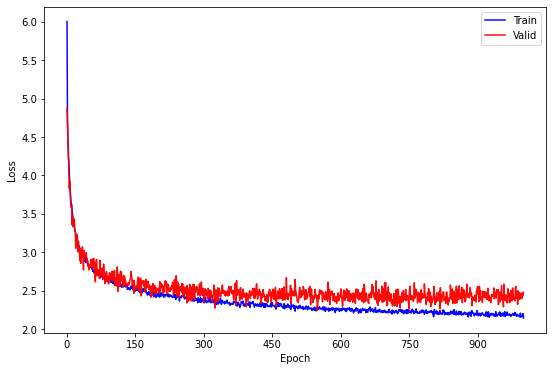

Finished!


In [20]:
if 'epoch' not in locals():
    valid_loss_history = []
    train_loss_history = []

    epoch = 1
    completed = False

elif not completed:
    optimizer.zero_grad()

begin_time = time()

if completed:
    begin_epoch = epoch
    epoch += 1
else:
    begin_epoch = epoch - 1

for epoch in range(epoch, n_epochs + 1):

    train_loss = 0
    network.train(True)

    completed = False
    for _ in range(n_batches_per_epoch):

        optimizer.zero_grad()

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))

        # clear old gradients; do a backward pass to get new gradients; then train with opt

        loss_t.backward()

        #nn.utils.clip_grad_norm_(network.parameters(), CLIP)

        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch
    train_loss_history.append(train_loss)

    val_loss = 0
    network.train(False)

    val_loss = sum(
        compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size)).item()
        for _ in range(n_validation_batches)
    )

    val_loss /= n_validation_batches

    valid_loss_history.append(val_loss)

    completed = True

    time_diff = time() - begin_time
    speed = time_diff / (epoch - begin_epoch)

    clear_output(True)

    print(
        f'Epoch: {epoch:13_}      Train loss: {train_loss:12.6}      Val loss: {val_loss:10.6}\n'

        f'Time elapsed: {int(time_diff):6_} sec  '
        f'Time remaining: {int((n_epochs - epoch) * speed):8_} sec  '
        f'Speed: {speed:13.6} ep/sec'
    )

    _cur_epoch_range = range(1, epoch + 1)

    fig = plt.figure(figsize=(9, 6))
    fig.gca().xaxis.set_major_locator(_mpl_integer_locator)
    plt.plot(_cur_epoch_range, train_loss_history, label='Train', color='b', alpha=0.97)
    plt.plot(_cur_epoch_range, valid_loss_history, label='Valid', color='r', alpha=0.97)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

del fig, epoch, begin_time, begin_epoch, completed


network.eval()

makedirs('models', exist_ok=True)
with open('models/hw04_basic_part2.pkl', 'wb') as out:
    pickle.dump(
        {k: v.cpu() for k, v in network.state_dict().items()},
        out
    )

print('Finished!')

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [21]:
from beheaded_inception3 import beheaded_inception_v3

inception = beheaded_inception_v3().train(False).to(device)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [22]:
def generate_caption(image,
                     caption_prefix=("#START#",),
                     t=1,
                     sample=True,
                     max_len=100,
                     *,
                     device=device):
    assert (
        isinstance(image, np.ndarray)
        and np.max(image) <= 1
        and np.min(image) >= 0
        and image.shape[-1] == 3
    )

    with torch.no_grad():
        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32, device=device)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64, device=device)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.cpu().numpy()

            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)  # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

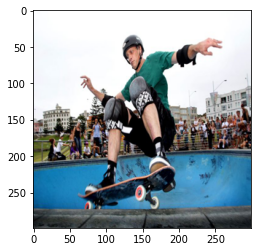

a man riding a skateboard up the side of a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard down a ramp .
a skateboarder is doing a trick on a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard up the side of a ramp .
a man riding a skateboard down a ramp .


In [23]:
def gen_for_image(url):

    with PoolManager() as pool:
        response = pool.request('GET', url)

    with BytesIO(response.data) as io:
        img = Image.open(io)
        img = np.array(img.resize((299, 299)), dtype=np.float32) / 255

    plt.imshow(img)
    plt.show()

    for i in range(10):
        print(' '.join(generate_caption(img, t=5)[1:-1]))


gen_for_image('https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg')

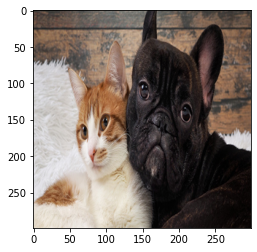

a cat laying on top of a white chair .
a cat laying on top of a white chair .
a cat is laying on a blanket on a couch
a cat is laying on top of a blanket .
a cat is laying on a blanket on a couch .
a cat laying on top of a blanket on a couch .
a cat is laying on a bed with a stuffed animal .
a cat is laying on a blanket in a bed .
a cat laying on top of a white blanket .
a cat laying on top of a bed next to a white wall .


In [24]:
gen_for_image('http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg')

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

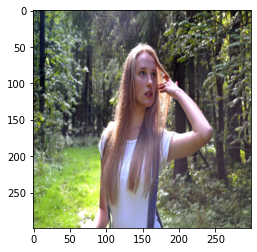

a woman is sitting on a bench with her legs crossed .
a woman is standing on a cell phone in the woods .
a woman is standing in front of a tree .
a woman is sitting on a bench with her legs crossed .
a woman is sitting on a bench in the woods .
a woman is sitting on a bench in the woods .
a woman is sitting on a bench talking on her cell phone .
a woman is standing on a bench with a dog .
a woman is sitting on a bench with her legs crossed .
a woman is holding a red frisbee in her hand .


In [25]:
gen_for_image('https://sun9-51.userapi.com/c628817/v628817136/16e1b/gUeIRfb0WAQ.jpg')

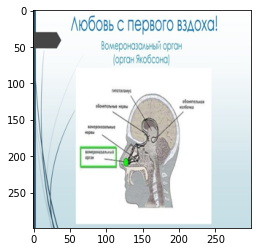

a person is holding a wii remote in their hand .
a person is holding a wii controller and a person in the background
a person is holding a pair of scissors
a picture of a person with a pair of scissors
a person is holding a wii controller and a person in the background .
a person holding a wii remote in their hand .
a picture of a man with a baseball bat .
a person holding a baseball bat in their hand .
a picture of a person with a pair of scissors
a person is holding a pair of scissors


In [26]:
gen_for_image('https://sun1-96.userapi.com/HU9E3n23p2Ym_xrKLCAS2WjFN7buPXHr3fdvLA/GyRBQQ42Usg.jpg')

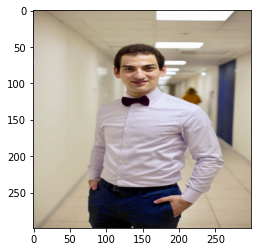

a man in a suit and tie is holding a camera .
a man with a tie and a tie
a man in a tie and a tie
a man in a suit and tie is smiling .
a man in a suit and tie is looking at a camera .
a man in a suit and tie is staring at the camera .
a man in a suit with a tie in his hand .
a man with a tie is standing in front of a mirror .
a man in a suit and tie is standing in front of a mirror .
a man in a suit and tie is smiling .


In [27]:
gen_for_image('https://sun9-30.userapi.com/c854228/v854228625/1b151c/gnMj-_I76Qg.jpg')

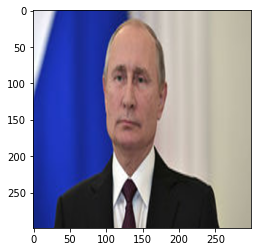

a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a building .
a man wearing a suit and tie and a tie .
a man wearing a suit and tie and a tie .
a man in a suit and tie standing in front of a building .
a man wearing a suit and tie .
a man wearing a suit and tie and a tie .
a man wearing a suit and tie and a tie .
a man in a suit and tie standing in front of a building .
a man in a suit and tie standing in front of a building .


In [28]:
gen_for_image('https://static.vl.ru/news/1583873369302_default')

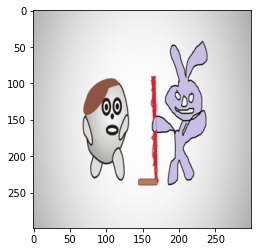

a bunch of different types of scissors in the shape of a heart .
a bunch of different types of scissors on a table .
a bunch of different types of scissors are on the table .
a bunch of different types of scissors are on a table .
a bunch of different types of scissors on a table .
a bunch of different types of scissors on a table .
a bunch of different types of scissors in the shape of a heart .
a group of people standing around a white frisbee .
a bunch of different types of scissors on a table .
a group of people are sitting on a bench .


In [29]:
gen_for_image(
    'https://meduza.io/impro/yQ2NxH5w6ut4rXqL8_C3FBgT0bxxCFu9ebzPFpo8jyk/'
    'fill/1300/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/'
    'aW1hZ2VzLzAwMC8w/MDYvNTQxL29yaWdp/bmFsL3B0QXN2N2FN/WjQtODczcW93dFVs/OFEuanBn.jpg'
)

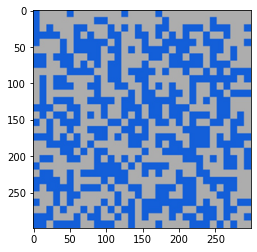

a red and white airplane flying high in the sky .
a small plane is flying in the air .
a small plane is flying in the sky .
a jet is flying in the air with a sky background
a small air plane is flying in the air .
a passenger jet flying high in the sky .
a small plane is flying in the sky .
a small bird flying in the air with a sky background
a small plane flying high in the sky
a blue and white jet flying in the air .


In [30]:
gen_for_image('https://sun1-24.userapi.com/DjIMeJ4tpBVu_haD8Qzz4nxwyuOLZYpDLXF58g/7jJk8d2DQTE.jpg')

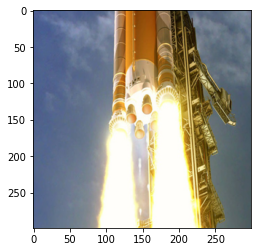

a large white and red fire hydrant on a city street .
a large white and red fire hydrant on a city street .
a large white building with a clock on the top of it .
a large white clock on a pole on a city street
a large group of people standing on a pole .
a large white building with a clock on top of it .
a large white and brown building with a clock on it .
a large group of people on a pair of skis .
a large white and red bird flying in the sky .
a large red and white bird flying high in the sky .


In [31]:
gen_for_image('https://sun1-30.userapi.com/1--v7TN1Gmyudrm02ZLnvCAPRcgXQi0KSBndVg/WnUHPwxksGk.jpg')

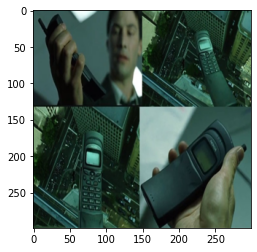

a desk with a keyboard and mouse on it
a desk with a keyboard , mouse and a keyboard
a desk with a keyboard and mouse on it
a desk with a keyboard and mouse on it
a computer keyboard sitting on a desk next to a mouse .
a person holding a cell phone in their hand .
a desk with a keyboard and a mouse
a computer keyboard sitting on top of a desk .
a desk with a keyboard and mouse on it
a laptop computer is on a desk in a room .


In [40]:
gen_for_image('https://sun1-16.userapi.com/a47n8eVxvgl_gTfwlt6ym8wNEABo7f49D24Fzw/3fbbLrxbejo.jpg')

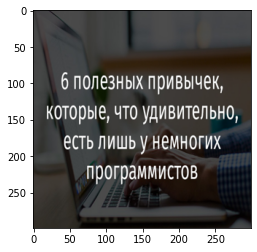

a close up of a sign on a wall
a close up of a sign with a message on it
a close up of a sign on a wooden pole
a red sign with a message on it .
a red stop sign sitting on a metal pole .
a close up of a samsung sign with a lamp on it
a close up of a samsung sign saying " #UNK# " .
a red and white sign with a message on it
a red stop sign sitting on a metal pole .
a close up of a sign on a wall


In [33]:
gen_for_image('https://sun1-14.userapi.com/v7ioJvq3xnJBG5p4PPsvzXMFtDy6cvWQaekt2w/jtrnLlLu1Os.jpg')

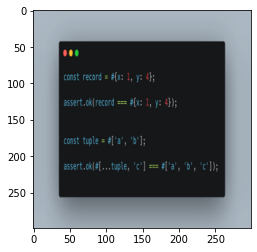

a close up of a vandalized parking meter
a close up of a vandalized street sign
a close up of a vandalized parking meter
a close up of a vandalized parking meter
a close up of a person holding a sign
a close up of a vandalized parking meter
a close up of a vandalized parking meter
a close up of a vandalized street sign
a close up of a sign on a pole
a close up of a vandalized street sign


In [34]:
gen_for_image('https://sun1-26.userapi.com/fr4zkXpKR4NYUaWLbbAgQnuRCFnHRbxR_Kk7LQ/FLMcCI3la1k.jpg')

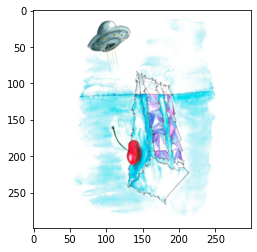

a pair of skis and a pair of skis
a bunch of people are flying kites in a field .
a large group of people on a beach flying kites .
a group of people on a beach flying kites .
a pair of skis and a pair of skis .
a pair of skis on a clear blue sky .
a pair of skis and a person in the air on a snowboard .
a pair of skis on a clear blue sky .
a bunch of people are flying kites on a beach .
a pair of skis on a clear blue sky .


In [35]:
gen_for_image('https://sun1-24.userapi.com/dqJyhMfeKBO0YUUGbFX75YjUyOUrpOQKGLP1kg/Wxr3POpBWN0.jpg')

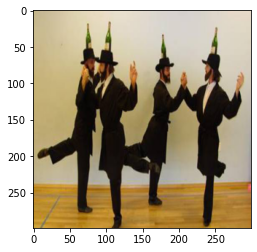

a group of people standing on top of a snow covered slope .
a man and woman are standing in the snow .
a group of people standing on top of a snow covered slope .
a group of people standing on top of a snow covered slope .
a group of people standing on top of a snow covered slope .
a group of people standing on top of a snow covered slope .
a group of people standing on top of a snow covered slope .
a group of people standing on a beach holding a surfboard .
a group of people standing on top of a snow covered slope .
a group of people standing on top of a sandy beach .


In [36]:
gen_for_image('http://nadym-worker.ru/cache/Article/2668/big/89508560_khava.jpg?1410492143')

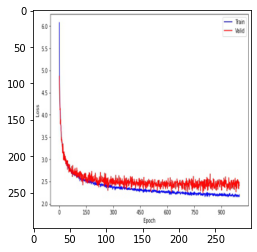

a blue and white fire hydrant on a city street .
a small yellow and blue fire hydrant on the side of a road .
a small yellow and blue fire hydrant on the side of a road .
a large yellow and blue fire hydrant on the side of a road .
a blue and yellow fire hydrant on the side of a road .
a small boat is in the water near a lighthouse .
a blue and white fire hydrant on the side of a road .
a small boat is on the water near a lighthouse .
a blue and white fire hydrant on a sidewalk .
a red fire hydrant in the middle of a city .


In [37]:
gen_for_image('https://sun9-37.userapi.com/y-cE-w49qlrCJnHIlWqABLP2pL7_2eYI2K_cFw/13mNASVfBI4.jpg')

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)